## Access and harmonisation of historical vector data on land-use/land-cover (LULC) - Open Street Map (OSM) data 

This block is aimed at semi-automatic extraction and harmonisation of open-access Open Street Map (OSM) data at various timestamps relevant for researches dealing with land-use/land cover data. Overpass Turbo API applied to fetch specific types of OSM features, including human-built infrastructure (roads and railways) and mostly natural features (inland waters - waterways and water bodies). No user authentication is required to access Overpass Turbo API, but it is advised to extract data in a reasonable manner at spatial scales such as Catalonia, Spain or Nothern England (69 925 km<sup>2</sup> and 20 650 km<sup>2</sup>, respectively) to avoid issues related to API throttling.

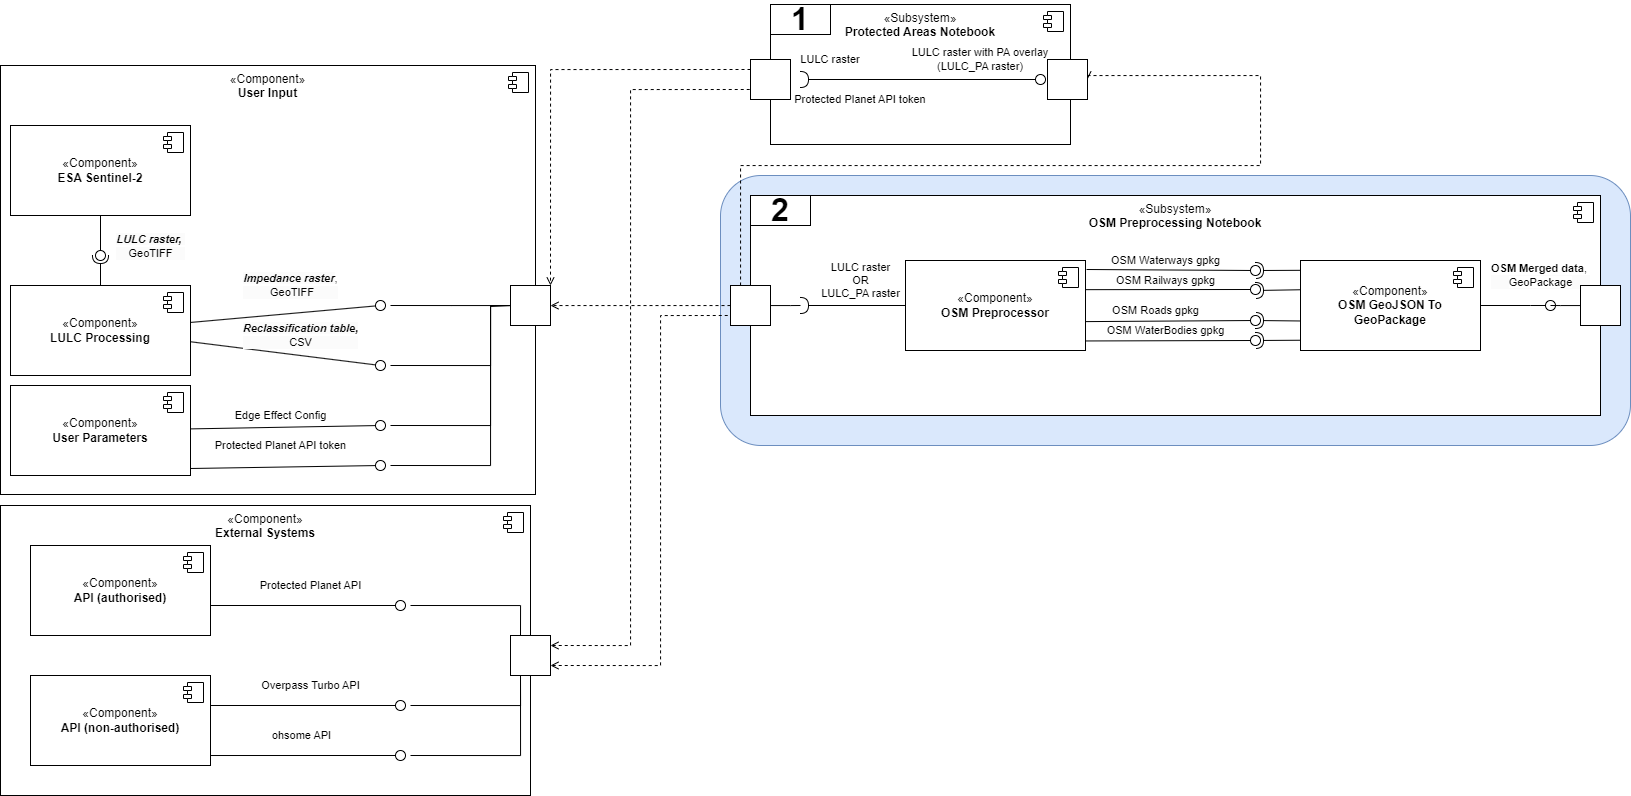

#### ***Limitations***
Limitations relevant to the further processing of habitat connectivity are multiple, but mostly caused by logical inconsistency and incompleteness of features (omissions) rather than geometrical and topological inconsistency, especially at older timestamps. The common problem of defining keys and values for filtering data is caused by the lack of relevant information for older timestamps (comprehensive OSM quides and manuals are mostly focused on current rules of assigning tags).
- Due to the active development of Open Street Map and increase in popularity since the launch, earlier timestamps from 2010s might lack a significant number of features compared to the current timestamp. For example, the total length of rivers and canals in Catalonia has increased by 27.3% from the end of the 2013 to 2022, while there were no significant nature- or human-driven changes in the water network. Such a change can be partly explained by the increase in the geometric data accuracy, smoothing and curving linear features, mapping linear features within water bodies, but it is also related to the increase in OSM popularity and adding other water features by new users.
- Some roads are missing key "surface". Therefore, paving of roads is not considered even though some narrow, unpaved and non-frequent roads might be crossed regularly by species.
- Some keys are not consistent throughout years (for example, level of roads is missing in data from 2012 and 2013 years).
- Presence of invalid numerical values (for example, width of roads = "3000" or "6 m" which requires additional preprocessing). Unique values by keys can be explored in detail here through [taginfo tool](https://taginfo.openstreetmap.org.uk/keys/width#values).
- Logical inconsistency in defining tags for types of roads throughout the years (can be defined as *'primary'*, and redefined as a *'secondary'* one later).
- Logical inconsistency in defining keys for water reservoirs (can be defined as *'land_use'* types instead of *'water'* types) at older timestamps (2012-2013).
- Changes in geometry types of water features - some rivers have been mapped as ways at older timestamps, but have been complemented with multipolygon features later. Was experienced in Catalonia (2012, 2013, 2017 timestamps).
- According to checks on the validity of vector data during the testing, waterbodies derived from Open Street Map might have invalid geometry, which might insignificantly complicate the further processing (0.01-0.04% from the total number of features, depending on the bounding box and timestamp).
- During the peak load on Overpass servers, bulky queries might be refused with error: *"Remote connection closed unexpectedly"* (faced with queries on roads). Quite high limit rates on memory consumption and query time are defined in this workflow by default but it is advised to fetch data from OSM at local or regional scale to prevent throttling issues.
- Queries on historical data with specified timestamp tend to be more time-consuming than the same ones without timestamps.

#### ***Processing issues***
- a few other ways to access historical OSM data were explored as well:
Nominatim API
Ohsome API
Geofabrik archives (do not provide automatic or semi-automatic access)
- ogr2ogr might interpret X and Y axis in a different order (flipping coordinates). This issue was detected for EPSG:27700 while merging separate geopackages into one even though no reprojection was specified  in flags. The solution is to define axis order explicitly through '-s_srs' (for the input dataset) and '-t_srs' (for the output dataset) flags as the same EPSG code.
- additional step is the translation of 'width' column into decimal one since geojson recognizes this column as a text. Currently, it is performed in further processing (enrichment of raster land-use/land-cover data) as a SQL statement for buffering roads by width from this column.

#### Initial setup
Let's import all libraries needed:

In [1]:
import json
import requests
import sys
import geopandas as gpd
import pandas as pd
import os
import tempfile
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon
from osgeo import gdal, osr
import pyproj

# auxiliary libraries
import time
import warnings
import yaml
import subprocess

import timing # own module
timing.start()

Let's specify the working directory:

In [ ]:
current_dir = os.getcwd()
# define child pa directory (level below)
input_dir = os.path.abspath(os.path.join(current_dir, 'data','input'))
os.makedirs(input_dir, exist_ok=True)
output_dir = os.path.abspath(os.path.join(current_dir, 'data','output'))
os.makedirs(output_dir, exist_ok=True)
# add the parent directory to sys.path
sys.path.append(current_dir)

#### Building Overpass Turbo API queries and access through Overpass endpoint
Now, we can define the preprocessor class to fetch Open Street Map data:

Let's define Overpass query for roads. Queries below extract ways and correspoding nodes automatically as it is crucial to record geometries of spatial features. It is also important to define a maximum size of memory consumption, otherwise issue of memory runout might arise for big queries.

Four main categories of OSM features are fetched:

1. Roads
2. Railways
3. Water lines (including natural and artificial ones)
4. Water bodies (also includes mistagged features with deprecated definitions to include them for older timestamps when rules for assigning tags were different (a query with actual tags is saved in comments)).

#### Output formats
There are two main options of output data formats - json and csv. Json is more bulky to transform to other spatial data formats and less flexible than csv, but another common library helps to quickly transform OSM jsons to geojsons easily - [osmtogeojson](https://wiki.openstreetmap.org/wiki/Overpass_turbo/GeoJSON). There are also other export options in the [official documentation](https://dev.overpass-api.de/output_formats.html): OSM XML, HTMPL popups and custom formats. However, these solutions are not stable.

UPD: CSV is fetched more quickly and it is suitable with larger sizes of data fetched (including multiple 'tertiary' roads), but coordinates from assigned nodes are glitched (order of nodes is mixed up). It might be possible to fix these issues related to the order of coordinates, but this workflow is not aimed at the optimisation of convertation since the stable solution of transforming json exists. Therefore, JSON has been chosen over CSV.

To use OSM JSON response further in preprocessing, [osmtogeojson](https://github.com/tyrasd/osmtogeojsonlibrary) is used (NPM is pre-installed within the docker container to get an access to osmtogeojson). At this step, non-suitable geometries (points and polygons for roads, railways and waterways) are filtered out. 

In [ ]:
from utils import load_yaml
from raster_metadata import RasterMetadata

class Osm_PreProcessor():
    """
    OSM (OpenStreetMap) Pre-Processor class to fetch OSM data for a given set of years and a bounding box.
    Currently only fetches for one year of OSM data.
    """
    def __init__(self, config_path:str, output_dir:str, default_year:int=2023) -> None:
        """
        Initialize the OSM Pre-Processor class with the configuration file and output directory.

        Args:
            config_path (str): the path to the configuration file
            output_dir (str): the output directory to save the intermediate files
            default_year (int): the default year to use if the year is not specified in the configuration file
        """
        self.config = load_yaml(config_path)
        self.output_dir = output_dir

        # make output directory if it does not exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        ## read year (Specify the input raster data)
        self.years = self.config.get('year', None)
        if self.years is None:
            warnings.warn(f"Year variable is null or not found in the configuration file... \n Defaulting to {default_year}.")
            self.years = [default_year]
            self.date = f"{self.years}-12-31T23:59:59Z" # to fetch it as a last second of the year
        elif isinstance(self.years, int):
            # cast to list
            self.years = [self.years]
            self.date = f"{self.years}-12-31T23:59:59Z"
        else:
            # cast to list
            self.years = [int(year) for year in self.years]
            self.date = [f"{year}-12-31T23:59:59Z" for year in self.years]

        print(f"OSM data is to be retrieved for {self.years} years.")
        print ("-" * 30)

        # find directories from config file
        input_dir = self.config.get('input_dir')
        lulc_dir = self.config.get('lulc_dir')

        ## define the input raster dataset that should be enriched with OSM data
        lulc_template = self.config.get('lulc')

        # substitute the year into the lulc string from config file
        # lulcs = [lulc_template.format(year=year) for year in self.years]
        lulc_series = {os.path.normpath(os.path.join(lulc_dir,lulc_template.format(year=year))):year for year in self.years}
        
        [print(f"Input rasters to be used for processing is {lulc}, {year}.") for lulc,year in lulc_series.items()]
        print ("-" * 30)

        # We can use the first raster to get the bounding box, as all rasters should have the same extent
        lulc = list(lulc_series.keys())[0]
        # NOTE: debug with the first year from list of lulcs
        self.first_year = list(lulc_series.values())[0] 
        self.lulc_metadata = RasterMetadata.from_raster(raster_path=lulc)
        self.bbox = self.reproject_and_get_bbox(self.lulc_metadata.x_min, self.lulc_metadata.x_max, self.lulc_metadata.y_min, self.lulc_metadata.y_max, self.lulc_metadata.crs_info['epsg'])
        # to check the bounding box of input raster
        print(self.bbox)

    def reproject_and_get_bbox(self, x_min_cart:float, x_max_cart:float, y_min_cart:float, y_max_cart:float, epsg_code:int) -> str:
        """
        Reproject the bounding box of input dataset as Overpass accepts only coordinates in geographical coordinates (WGS 84).

        Args:
            x_min_cart (float): the minimum x-coordinate in Cartesian coordinates
            x_max_cart (float): the maximum x-coordinate in Cartesian coordinates
            y_min_cart (float): the minimum y-coordinate in Cartesian coordinates
            y_max_cart (float): the maximum y-coordinate in Cartesian coordinates
            epsg_code (int): the EPSG code of the input raster dataset

        Returns:
            str: a str containing the reprojected bounding box (x_min, y_min, x_max, y_max)
        """
        ## Reproject the bounding box of input dataset as Overpass accepts only coordinates in geographical coordinates (WGS 84):
        # defining function to transform
        transform_cart_to_geog = pyproj.Transformer.from_crs(
            pyproj.CRS(f'EPSG:{epsg_code}'),  # applying EPSG code of input raster dataset
            pyproj.CRS('EPSG:4326')   # WGS84 geographic which should be used in OSM APIs
        )

        # running function
        x_min, y_min = transform_cart_to_geog.transform(x_min_cart, y_min_cart)
        x_max, y_max = transform_cart_to_geog.transform(x_max_cart, y_max_cart)

        # print the Cartesian coordinates before transformation
        print("Before Transformation:")
        print("x_min_cart:", x_min_cart)
        print("x_max_cart:", x_max_cart)
        print("y_min_cart:", y_min_cart)
        print("y_max_cart:", y_max_cart)

        # print the transformed geographical coordinates
        print("After Transformation:")
        print("x_min:", x_min)
        print("x_max:", x_max)
        print("y_min:", y_min)
        print("y_max:", y_max)
        bbox=f"{x_min},{y_min},{x_max},{y_max}"
        
        return bbox

    def fetch_osm_data(self,queries:dict, year:int , overpass_url:str = "https://overpass-api.de/api/interpreter") -> list:
        """
        A function to fetch OSM data for a given set of queries and a year.

        Args:
            queries (dict): a dictionary of queries
            year (int): the year of the data
            overpass_url (str): the URL of the Overpass API

        Returns:
            list: a list of intermediate JSON files
        """

        intermediate_jsons = []

        # iterate over the queries and execute them
        for query_name, query in queries.items():
            response = requests.get(overpass_url, params={'data': query})
            print(response)
                
            # if response is successful
            if response.status_code == 200:
                print(f"Query to fetch OSM data for {query_name} in the {year} year has been successful.")
                data = response.json()
                
                # Extract elements from data
                elements = data.get('elements', [])
                
                # Print the number of elements
                print(f"Number of elements in {query_name} in the {year} year: {len(elements)}")
                
                # Print the first 3 elements to verify response
                for i, element in enumerate(elements[:3]):
                    print(f"Element {i+1}:")
                    print(json.dumps(element, indent=2))
                
                # Save the JSON data to a file
                output_file = os.path.join(self.output_dir, f"{query_name}_{year}.json")
                with open(output_file, 'w', encoding='utf-8') as f:
                    json.dump(data, f, ensure_ascii=False, indent=4)
                print(f"Data has been saved to {output_file}")
                print ("-" * 30)

                # Add the output file name to the list
                intermediate_jsons.append(output_file)
                
            else:
                print(f"Error: {response.status_code} for {query_name} in the {year} year")
                print(response.text)
                print ("-" * 30)

        return intermediate_jsons

    def overpass_query_builder(self, year:int, bbox:str) -> dict[str, str]:
        """
        A function to build the queries for Overpass API for a given year and bounding box, for roads, railways, waterways, and waterbodies.

        Args:
            year (int): the year of the data
            bbox (str): the bounding box to query
        
        Returns:
            dict: a dictionary of queries for roads, railways, waterways, and waterbodies
        """
        #TODO: The data limit is 1GB. Could try split the query into smaller parts (bounding boxes) and run them separately.
        #NOTE: the issue with the above is that you might get IP blocked by the server. So, need to be careful with this.
        query_roads = f"""
        [out:json]
        [maxsize:1073741824]
        [timeout:9000]
        [date:"{year}-12-31T23:59:59Z"]
        [bbox:{bbox}];
        way["highway"~"(motorway|trunk|primary|secondary|tertiary)"];
        /* also includes 'motorway_link',  'trunk_link' etc. because they also restrict habitat connectivity */
        (._;>;);
        out body;
        """
        # '{' characters must be doubled in Python f-string (except for {bbox} because it is a variable)
        # to include statement on paved surfaces use: ["surface"~"(paved|asphalt|concrete|paving_stones|sett|unhewn_cobblestone|cobblestone|bricks|metal|wood)"];
        # it is important to include only paved roads it is important to list all values above, not only 'paved'*/
        # BUT! : 'paved' tag seems to be missing in a lot of features at timestamps from 2010s
        # 'residential' roads are not fetched as these areas are already identified in land-use/land-cover data as urban or residential ones
        # "~" extracts all tags containing this text, for example 'motorway_link'
        
        query_railways = f"""
        [out:json]
        [maxsize:1073741824]
        [timeout:9000]
        [date:"{year}-12-31T23:59:59Z"]
        [bbox:{bbox}];
        way["railway"~"(rail|light_rail|narrow_gauge|tram|preserved)"];
        (._;>;);
        out;
        """
        
        # way["railway"];  # to include features if 'railway' key is found (any value)
        # to include features with values filtered by key. 
        # This statement also includes 'monorail' which are not obstacles for species migration, but these features are extremely rare. Therefore, it was decided not to overcomplicate the query.
        # 31/07/2024 - added filtering on 'preserved' railway during the verification by UKCEH LULC dataset (some railways are marked as 'preserved at older timestamps and 'rail' in newer ones).
    
        query_waterways = f"""
        [out:json]
        [maxsize:1073741824]
        [timeout:9000]
        [date:"{year}-12-31T23:59:59Z"]
        [bbox:{bbox}];
        (
        way["waterway"~"^(river|canal|flowline|tidal_channel)$"];
        way["water"~"^(river|canal)$"];
        );
        /* ^ and $ symbols to exclude 'riverbank' and 'derelict_canal'*/
        /*UPD - second line is added in case if some older features are missing 'way' tag*/
        (._;>;);
        out;
        """

        # Query to bring water features with deprecated tags
        query_waterbodies = f"""
        [out:json]
        [maxsize:1073741824]
        [timeout:9000]
        [date:"{year}-12-31T23:59:59Z"]
        [bbox:{bbox}];
        (
        nwr["natural"="water"];
        nwr["water"~"^(cenote|lagoon|lake|oxbow|rapids|river|stream|stream_pool|canal|harbour|pond|reservoir|wastewater|tidal|natural)$"];
        nwr["landuse"="reservoir"];
        nwr["waterway"="riverbank"];
        /*UPD - second filter was added to catch other water features at all timestamps*/
        /*UPD - third and fourth filters were added to catch other water features at older timestamps*/
        /*it is more reliable to query nodes, ways and relations altogether ('nwr') to fetch the complete polygon spatial features*/
        );
        (._;>;);
        out;
        """
        
        # to include small waterways use way["waterway"~"(^river$|^canal$|flowline|tidal_channel|stream|ditch|drain)"]

        # merge queries into dictonary
        # to include all queries
        return {"roads":query_roads, "railways":query_railways, "waterways":query_waterways, "waterbodies":query_waterbodies}
    

    def convert_to_geojson(self, queries:dict[str,str], year:int):
        """
        A function to convert the intermediate JSON files to GeoJSON files

        Args:
            queries (dict): a dictionary of queries
            year (int): the year of the data

        Returns:
            None: Writes the GeoJSON files to the output directory
        """
        for query_name, query in queries.items():
            input_file = os.path.join(self.output_dir, f"{query_name}_{year}.json")
            output_file = os.path.join(self.output_dir, f"{query_name}_{year}.geojson")
            result = subprocess.run(['osmtogeojson', input_file], capture_output=True, text=True)
            if result.returncode == 0:
                print(f"Conversion to GeoJSON for {query_name} in the {year} year was successful.")
                with open(output_file, 'w', encoding='utf-8') as f:
                    f.write(result.stdout)
            else:
                print(f"Conversion to GeoJSON for {query_name} in the {year} year failed.")
                print(result.stderr)
            

    def fix_invalid_geometries(self, queries:dict[str,str], year:int ,overwrite_original:bool):
        """
        A function to fix invalid geometries in the GeoJSON files

        Args:
            queries (dict): a dictionary of queries
            year (int): the year of the data
            overwrite_original (bool): overwrite the original GeoJSON files (True) or create new ones (False) *_filtered.geojson

        Returns:
            list: a list of fixed GeoJSON files
        """
        geojson_files=[]

        # iterate over the queries and define outputs
        for query_name, query in queries.items():
            geojson_file = os.path.join(self.output_dir, f"{query_name}_{year}.geojson")

            # check if the non-zero GeoJSON files exist
            if os.path.exists(geojson_file) and os.path.getsize(geojson_file) > 0:
                print(f"Conversion to GeoJSON for {query_name} in the {year} year was successful.")
                
                # read the GeoJSONs
                with open(geojson_file, 'r', encoding='utf-8') as f:
                    geojson_data = json.load(f)
                    features = geojson_data.get('features', [])
                    print(f"Total features: {len(features)}")
                    
                # determine the geometries to filter based on query_name
                # for roads, railways and waterways extract only lines and multilines
                if query_name in ("roads", "railways", "waterways"):
                    geometry_types = ['LineString', 'MultiLineString']
                    # filter based on geometry types and level - it should be 0 (or null)
                    filtered_features = [
                        feature for feature in geojson_data.get('features', [])
                        if feature['geometry']['type'] in geometry_types
                        and (feature['properties'].get('level') in (None, 0)) # filtering by ground level of infrastructure
                    ]
                # for waterbodies extract only polygons and multipolygons
                elif query_name == "waterbodies":
                    geometry_types = ['Polygon', 'MultiPolygon']
                    # filter based on geometry types only
                    filtered_features = [
                        feature for feature in geojson_data.get('features', [])
                        if feature['geometry']['type'] in geometry_types
                    ]
                # for everything else extract everything that can be found
                else:
                    filtered_features = [
                        feature for feature in geojson_data.get('features', [])
                    ]

                # cast all property keys to lowercase (to avoid issues with case sensitivity for future notebooks)
                filtered_features = [
                    {
                        k: {property_key.lower(): property_value for property_key, property_value in v.items()} if k == "properties" else v
                        for k, v in feature.items()
                    }
                    for feature in filtered_features
                ]
                # create a new GeoJSON structure with filtered features
                filtered_geojson_data = {
                    "type": "FeatureCollection",
                    "features": filtered_features
                }

                print(f"Total features after filtering {query_name} in the {year} year: {len(filtered_features)}")
                print ("-" *30)
                
                # create new file 
                if overwrite_original == False:
                    geojson_file = os.path.join(self.output_dir, f"{query_name}_{year}_filtered.geojson")
                
                # overwrite the original GeoJSON file with the filtered one
                with open(geojson_file, 'w', encoding='utf-8') as f:
                    json.dump(filtered_geojson_data, f, ensure_ascii=False, indent=4)

                # write filenames to the list with intermediate geojsons
                geojson_files.append(geojson_file)
            
            else:
                print(f"Conversion to GeoJSON for {query_name} in the {year} year failed.")
                print ("-" *30)

        return geojson_files

In [29]:
osm_data_dir = os.path.join(output_dir,'osm_data')
os.makedirs(osm_data_dir, exist_ok=True)
osm = Osm_PreProcessor(os.path.join(current_dir,"config","config.yaml"),osm_data_dir)

# NOTE: loop Fetches OSM data for all years. repeat queries may cause IP blocking by the server
for year in osm.years:
    queries = osm.overpass_query_builder(year=year, bbox=osm.bbox)
    #osm.fetch_osm_data(queries=queries, year=year)
    osm.convert_to_geojson(queries=queries, year=year)
    osm.fix_invalid_geometries(queries=queries,year=year,overwrite_original=True)

# # test with one year
# queries = osm.overpass_query_builder(osm.first_year, bbox= osm.bbox)
# osm.fetch_osm_data(queries=queries, year=osm.first_year)
# osm.convert_to_geojson(queries=queries)
# osm.fix_invalid_geometries(queries=queries,year=osm.first_year,overwrite_original=False)

#### Postprocessing outputs
Then, geojson datasets should be converted into geopackages since they are more optimised for further processing. *The quickest way to perform the conversion is ogr2ogr library executed as a shell script (currently executed through subprocess).*

We also reprojected OSM data to align with input raster dataset's coordinate system.

*Computation time of this block doesn't differ from the same block executed through the shell script.*

*Additional step is the translation of 'width' column into decimal one since geojson recognizes this column as a text. Currently, it is performed in further processing as a SQL statement for buffering roads by width from this column.*

In [8]:
# import os

# def convert_geojson_to_gpkg(input_geojson, output_gpkg, target_epsg=4326):
#     """
#     Convert a GeoJSON file to a GeoPackage file with a specified target EPSG code.

#     Args:
#         input_geojson (str): the input GeoJSON file
#         output_gpkg (str): the output GeoPackage file
#         target_epsg (int): the target EPSG code (default is 4326)

#     Returns:
#         None: Writes the GeoPackage file to the output directory
#     """
#     # run function as a shell script through subprocess library
#     result = subprocess.run(['ogr2ogr', '-f', 'GPKG', '-t_srs', f'EPSG:{target_epsg}', output_gpkg, input_geojson], 
#                             check=True, 
#                             capture_output=True, 
#                             text=True)
    
#     print(f"Converted and modified to GeoPackage: {output_gpkg}")
#     #check error code
#     if len(result.stderr) > 0:
#         print(f"Warnings or errors:\n{result.stderr}")
    
                    
# # Example usage
# input_geojson = os.path.join('data/input/osm', 'waterbodies_2018_filtered.geojson')
# output_gpkg = os.path.join('data/input/osm/gpkg_temp', 'test.gpkg')
# convert_geojson_to_gpkg(input_geojson, output_gpkg)

# OSM GeoJsons into merged geopackage, and fix geometries

In [49]:
import shutil
from osgeo import ogr

class OsmGeojson_to_gpkg():
    """
    A class to convert GeoJSON files to GeoPackage files and merge them into a single GeoPackage file.
    """

    def __init__(self, osm_data_dir:str, gpkg_dir:str, target_epsg:str, year:int, file_ending:str) -> None:
        """
        Initialize the OsmGeojson_to_gpkg class with the input directory, output directory, and target EPSG code.

        Args:
            osm_data_dir (str): the input directory containing GeoJSON files
            gpkg_dir (str): the output directory to save the GeoPackage files
            target_epsg (str): the target EPSG code to reproject the GeoJSON files to
            year (int): the year of the osm data to be processed
            file_ending (str): the file ending of the GeoJSON files (use 'filtered.geojson' if new files are made, 'geojson' if old files are used)
        """

        self.osm_data_dir = osm_data_dir
        # create output directory if it does not exist
        os.makedirs(gpkg_dir, exist_ok=True)
        self.gpkg_dir = gpkg_dir
        self.target_epsg = target_epsg
        # replace .geojson with .gpkg for each file
        self.gpkg_files = [file.replace('.geojson', '.gpkg') for file in self.convert_geojson_to_gpkg(year, file_ending)]
        print(self.gpkg_files)

    def convert_geojson_to_gpkg(self, year:int, file_ending:str='filtered.geojson') -> list:
        """
        Convert all GeoJSON files in the input directory to GeoPackage files with the target EPSG code.

        Args:
            year (int): the year of osm data to be processed
            file_ending (str): the file ending of the GeoJSON files (default is 'filtered.geojson')

        Returns:
            list: a list of GeoJSON files
        """

        # loop through all geojson files in directory
        geojson_files = []
        file_ending = f"{year}.{file_ending}"
        for filename in os.listdir(self.osm_data_dir):
            if filename.endswith(file_ending):
                geojson_file = os.path.join(self.osm_data_dir, filename)
                geopackage_file = os.path.join(self.gpkg_dir, filename.replace('.geojson', '.gpkg'))
            
                try:
                    # run function as a shell script through subprocess library
                    result = subprocess.run(['ogr2ogr', '-f', 'GPKG', '-t_srs', f'EPSG:{self.target_epsg}', geopackage_file, geojson_file], 
                                            check=True, 
                                            capture_output=True, 
                                            text=True)
                    
                    print(f"Converted and modified to GeoPackage: {filename}")

                    #check error code
                    if len(result.stderr) > 0:
                        print(f"Warnings or errors:\n{result.stderr}")

                    # append filenames with a list
                    geojson_files.append(filename)

                except subprocess.CalledProcessError as e:
                    print(f"Error processing {filename}: {e}")
                except Exception as e:
                    print(f"Unexpected error with {filename}: {e}")

        # return the list of GeoJSON files
        return geojson_files
    
    def merge_gpkg_files(self, output_file:str, year:int):
        """
        Merge all GeoPackage files into a single GeoPackage file.

        Args:
            output_file (str): the output GeoPackage file
            year (int): the year of the data (from OSM_PreProcessor)

        Returns:
            None: Writes the merged GeoPackage file to the output directory
        """
        
        # debug print the list of GeoPackage files
        # print(self.gpkg_files)

        # initialize the GeoPackage using the first GeoPackage file
        first_gpkg_file = self.gpkg_files[0]
        layer_name = first_gpkg_file.split(f"_{year}")[0]
        first_gpkg_file = os.path.join(self.gpkg_dir, first_gpkg_file)

        subprocess.run(['ogr2ogr', '-f', 'GPKG', output_file, first_gpkg_file, # output and input files
                '-s_srs', f'EPSG:{self.target_epsg}',  # set source CRS
                '-t_srs', f'EPSG:{self.target_epsg}', # set target CRS
                '-nln', layer_name # specify name of the layer
                ], check=True, capture_output=True, text=True) # to show log
        print(f"Initialized merged GeoPackage with CRS EPSG:{self.target_epsg} from {layer_name}.")

        for gpkg_file in self.gpkg_files[1:]:  # skip the first file because it's already added
            layer_name = gpkg_file.split(f"_{year}")[0]
            gpkg_file = os.path.join(self.gpkg_dir, gpkg_file)
            # run appending separate geopackages to empty merged geopackage (update if layers were previously written)
            try:
                result = subprocess.run(['ogr2ogr', '-f', 'GPKG', output_file, '-s_srs', f'EPSG:{self.target_epsg}', # for input file
                                                '-t_srs', f'EPSG:{self.target_epsg}', # for output file
                                                '-nln', layer_name, '-update', '-append', gpkg_file],
                                                check=True, 
                                                capture_output=True, 
                                                text=True)
                
                print(f"Added layer {layer_name} from {gpkg_file} to {output_file}")
                if len(result.stderr) > 0:
                    print(f"Warnings or errors:\n{result.stderr}")

            except subprocess.CalledProcessError as e:
                print(f"Error adding {layer_name}: {e.stderr}")
            except Exception as e:
                print(f"Unexpected error with {layer_name}: {e}")

    def fix_geometries_in_gpkg(self, input_gpkg:str, fixed_gpkg_path:str=None) -> str:
        """
        Fix invalid geometries in a GeoPackage file and save the fixed geometries to a new GeoPackage file.
        If fixed_gpkg is not specified, the input GeoPackage file will be overwritten.

        Args:
            input_gpkg (str): the input GeoPackage file
            fixed_gpkg_path (str): the output path for the fixed GeoPackage file (default is None)
        Returns:
            str: the path to the fixed GeoPackage file
        """

        # if fixed_gpkg is not specified, overwrite the input_gpkg
        copy_gpkg = False
        if fixed_gpkg_path is None:
            fixed_gpkg_path = input_gpkg
        else:
            shutil.copyfile(input_gpkg, fixed_gpkg_path) # to copy file to a new one
            copy_gpkg = True

        # open the output GeoPackage for editing
        data_source = ogr.Open(fixed_gpkg_path, update=1)

        for i in range(data_source.GetLayerCount()):
            layer = data_source.GetLayerByIndex(i)
            layer_name = layer.GetName()
            feature_to_fix_count = 0
            fixed_feature_count = 0
            invalid_feature_count = 0

            # iterate over all features in the layer
            for feature in layer:
                geometry = feature.GetGeometryRef()
                if not geometry.IsValid():
                    feature_to_fix_count += 1 # increment the number of features to be fixed
                    # attempt to fix the geometry
                    fixed_geometry = geometry.MakeValid()

                    if fixed_geometry.IsValid():
                        # replace the geometry with the fixed one
                        feature.SetGeometry(fixed_geometry)
                        layer.SetFeature(feature)  # save the updated feature back to the layer
                        print(f"Fixed invalid geometry in layer '{layer_name}', feature ID: {feature.GetFID()}")
                        fixed_feature_count += 1 # increment the number of fixed features
                    else:
                        print(f"Could not fix geometry in layer '{layer_name}', feature ID: {feature.GetFID()}")
                        invalid_feature_count += 1 # increment the number of features that cannot be fixed

        if feature_to_fix_count == 0:
            print (f"All geometries of features in the layer '{layer_name}' of the output vector are valid.")
            print("-" * 40)
        else:
            print(f"Layer '{layer_name}: {fixed_feature_count} geometries fixed.") 
            print(f"Layer '{layer_name}': {invalid_feature_count} geometries could not be fixed.")
            print("-" * 40)

        # close the data source
        del data_source

        # return the path to the fixed GeoPackage file
        if copy_gpkg == True:
            return fixed_gpkg_path
        else:
            return input_gpkg
    
    def delete_temp_files(self, delete_geojsons:bool=True, delete_gpkg_files:bool=True):
        """
        Delete all intermediate GeoJSON files to save disk space.
        
        Args:
            delete_geojsons (bool): whether to delete GeoJSON files (default is True)
            delete_gpkg_files (bool): whether to delete GeoPackage files (default is True)
        Returns:
            None: Deletes all intermediate GeoJSON files from osm data directory
        """
        # delete all GeoJSON files
        if delete_geojsons:
            for file in os.listdir(self.osm_data_dir):
                if file.endswith('.geojson'):
                    os.remove(os.path.join(self.osm_data_dir, file))
            print(f"Deleted all GeoJSON files from {self.osm_data_dir}")
        
        if delete_gpkg_files:
            for file in os.listdir(self.gpkg_dir):
                if file.endswith('.gpkg'):
                    os.remove(os.path.join(self.gpkg_dir, file))
            print(f"Deleted all GeoPackage files from {self.gpkg_dir}")

In [ ]:
# run the conversion and modification of GeoJSON files to GeoPackage files for all years
gpkg_dir = os.path.join(osm_data_dir, 'gpkg_temp')
# add a vector_dir (a subdirectory of input_dir), to store the merged geopackage of osm data
vector_dir = os.path.abspath(os.path.join(input_dir, 'vector'))
os.makedirs(vector_dir, exist_ok=True)

for year in osm.years:
    ogtg = OsmGeojson_to_gpkg(osm_data_dir,gpkg_dir,target_epsg=4326, year=year, file_ending='geojson')
    output_file = os.path.join(gpkg_dir, f'osm_merged_{year}.gpkg') # osm.year added from OSM_PreProcessor class 
    fixed_gpkg_path = os.path.join(gpkg_dir, f'osm_merged_{year}_fixed.gpkg')
    ogtg.merge_gpkg_files(output_file, year)
    gpkg_path = ogtg.fix_geometries_in_gpkg(output_file, fixed_gpkg_path)
    #Move file to vector_dir for next notebook
    shutil.move(gpkg_path, os.path.join(vector_dir, f'osm_merged_{year}.gpkg'))

#once all years are processed, delete the temp files
ogtg.delete_temp_files(delete_geojsons=True, delete_gpkg_files=True)

# input_dir = os.path.join(os.getcwd(), 'data/input/osm')
# output_dir = os.path.join(input_dir, 'gpkg_temp')
# ogtg = OsmGeojson_to_gpkg(input_dir,output_dir,target_epsg=4326)
# output_file = os.path.join(output_dir, f'osm_merged_{osm.first_year}.gpkg') # osm.year added from OSM_PreProcessor class 
# fixed_gpkg = os.path.join(output_dir, f'osm_merged_{osm.first_year}_fixed.gpkg')
# ogtg.merge_gpkg_files(output_file, osm.first_year)
# ogtg.fix_geometries_in_gpkg(output_file, fixed_gpkg, overwrite_original=False)
# ogtg.delete_temp_files()
# #NOTE remember to move file to vector_dir for next notebook
# shutil.move(fixed_gpkg, os.path.join(os.getcwd(),  f'data/input/vector/osm_merged_{year}.gpkg')'))

Let's find out how much time does it take to extract and optimise this dataset:

In [51]:
timing.stop()